<h1>Levenberg-Marquardt Tensorflow Based Implementation</h1>
<h2>Introduction</h2>
The Levenberg-Marquardt (LM) algorithm is the most widely used optimization algorithm. It outperforms simple gradient descent and other conjugate gradient methods in a wide variety of problems. This tutorial demonstrates LM implementation using Tensorflow to optimize MLP neural networks.
<h2>Imports</h2>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import math
%matplotlib inline

C:\Python64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<h2>Rosenbrock function</h2>
We will use Rosenbrock function as a performance test problem. Let's start with its two variables form: <i>f(x, y) = (a - x)^2 + b(y - x^2)^2</i>.

In [2]:
def rosenbrock(x, y, a, b):
    return (a - x)**2 + b*(y - x**2)**2

# consider this function on the square [-2,2]x[-2,2]
x_grid, y_grid = np.meshgrid(np.arange(-2, 2.1, 0.1), 
                             np.arange(-2, 2.1, 0.1))
# with parameters a = 0.5 and b = 0.5
z_grid = rosenbrock(x_grid, y_grid, 0.5, 0.5)

<h2>Helper-function for plotting</h2>

In [3]:
GRAY1 = '#646369'
BLUE1, BLUE2 = '#4A81BF', '#174A7E'

def prepare_3d_plot_for_rosenbrock():
    fig = plt.figure(figsize=(7, 5), dpi=110)
    ax = fig.add_subplot(111, projection='3d')
    # configure tick labels appearance
    for i in ax.get_yticklabels() + ax.get_xticklabels() + ax.get_zticklabels():
        i.set_fontsize(8)
        i.set_color(GRAY1)
    ax.view_init(40, 80)
    return ax

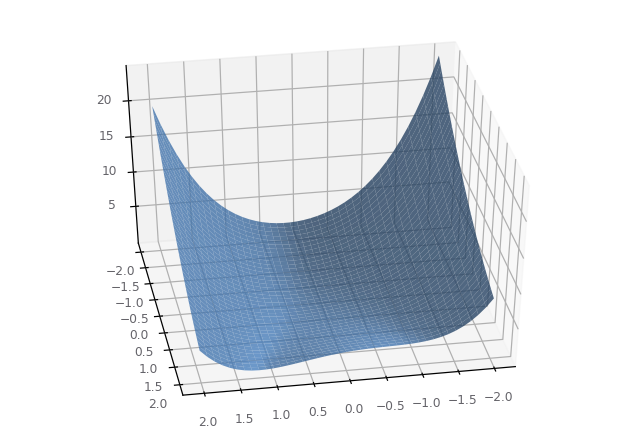

In [4]:
# let's plot it
ax = prepare_3d_plot_for_rosenbrock()
ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.8, color=BLUE1)

<h2>The Problem</h2>
The problem for which the LM algorithm provides a solution is called <i>Nonlinear Least Squares Minimization</i>. Suppose from an experiment we have as set of <i>m</i> data points, <i>(x1, y1, z1), (x2, y2, z2),..., (xm, ym, zm)</i>. Our goal is to be able to predict <i>z</i> for other values <i>(x, y)</i>. We have a model function <i>z = rosenbrock(x, y, a, b)</i>, that in addition to the variables <i>(x, y)</i> also depends on parameters <i>a, b</i>. It is desired to find these parameters such that the surface fits best the given data in the least squares sense.

In [5]:
# generate some data points from an "experiment"
data_points = np.array([[x, y, rosenbrock(x, y, 0.5, 0.5)]
                       for x in np.arange(-2, 2.1, 2) 
                       for y in np.arange(-2, 2.1, 2)])
m = data_points.shape[0]

# now, please, forget about actual paramenters (0.5, 0.5)
# suppose they are unknown and our goal is to estimate them 
# using only data_points and knowledge about our model

# we start with guessing
a_guess, b_guess = 5., 5.
# predictions usually have -hat suffix
z_hat = rosenbrock(data_points[:,0], data_points[:,1], a_guess, b_guess)
# residual is the difference between the measured value and the predicted value
r = data_points[:,2] - z_hat
# calculate the squared residuals sum in one line of code
# by multiplying a row vectory by itself column vector
loss = r.dot(r.T)/m
# our guess is bad :(. Let's try another guess?
print(loss)

10926.5625


<h2>The Problem Graphical Representation</h2>
We can plot the data points from the experiment as dots, our model as a suface and the residuals as lines connecting data dots to the model surface. See how far the data points are from the model. We need to find better <i>a, b</i> to make it closer.

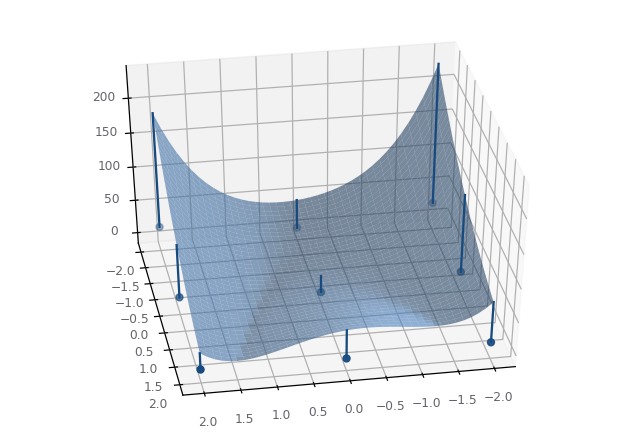

In [6]:
ax = prepare_3d_plot_for_rosenbrock()
# plot data points from an experiment
ax.scatter(data_points[:,0], 
           data_points[:,1], 
           data_points[:,2], 
           color=BLUE2)
# plot our model surface 
z_hat_grid = rosenbrock(x_grid, y_grid, a_guess, b_guess)
ax.plot_surface(x_grid, y_grid, z_hat_grid, alpha=0.6, color=BLUE1)
# plot residuals as lines
for i in range(m):
    ax.plot([data_points[i, 0], data_points[i, 0]], 
            [data_points[i, 1], data_points[i, 1]], 
            [data_points[i, 2], z_hat[i]], c=BLUE2)

<h2>Tensorflow Problem Definition</h2>
From now let's start using more common convention for naming. Instead of <i>z = f(x, y, a, b)</i> we'll use <i>y = f(x, a, b)</i>, where <i>x</i> is vector. In the case of 2D rosenbrock it is a vector of 2. On the next step we'll construct so-called computational graph. Please, note that no actual computation is performed.

In [7]:
# placeholder variables (we have m data points)
x = tf.placeholder(tf.float64, shape=[m, 2])
y = tf.placeholder(tf.float64, shape=[m])

# variables to be optimized with initial guess
a = tf.Variable(a_guess, dtype=tf.float64)
b = tf.Variable(b_guess, dtype=tf.float64)

# model 
x1, x2 = x[:, 0], x[:, 1]
y_hat = (a - x1)**2 + b*(x2 - x1**2)**2

#cost-function to be optimized
loss = tf.reduce_mean(tf.square(y - y_hat))

In [8]:
# construct so-called feed dictionary to map placeholders to actual values
feed_dict = {x: data_points[:,0:2], y: data_points[:,2]}

<h2>TensorFlow Run</h2>

In [9]:
# create TensorFlow session
session = tf.Session()
# initialize variables
session.run(tf.global_variables_initializer())
# calculate loss using tensorflow  if everything is correct, 
# the loss equals to the previously calcualted by means of numpy
current_loss = session.run(loss, feed_dict)
print(current_loss)

10926.5625


<h2>Optimization method</h2>
Now that we have a model and a loss measure that must be minimized, we can then create an optimizer. Levenberg-Marquardt is a mixture of Newton-Gauss and a basic form of Gradient Descent. Let's start with Gradient Descent. There is an easy way to create an optimizer, but let's do some more work and implement it ourselves.
<h3>Training Loop</h3>
Let's start with a simple training loop and write a helper function.

In [10]:
def train(target_loss, max_steps, loss, train_step, inputs):
    step = 0
    # calc initial loss
    current_loss = session.run(loss, inputs)
    while current_loss > target_loss and step < max_steps:
        step += 1
        if math.log(step, 2).is_integer():
            print(f'step: {step}, current loss: {current_loss}')
        session.run(train_step, inputs)
        current_loss = session.run(loss, inputs)
    print(f'ENDED ON STEP: {step}, FINAL LOSS: {current_loss}')

<h3>SGD Optimization</h3>

In [11]:
# create an optimizer object
opt = tf.train.GradientDescentOptimizer(learning_rate=1)

# calculate the partial derivatives of the loss function with respect to a and b
a_grad, b_grad = tf.gradients(loss, [a, b])

# set the learning rate 
learning_rate = 0.0005
a_grad, b_grad = a_grad*learning_rate, b_grad*learning_rate

# define the SGD step
sgd = opt.apply_gradients([(a_grad, a), (b_grad, b)])

In [12]:
# let's run SGD optimization
session.run(tf.global_variables_initializer())
train(1e-10, 40000, loss, sgd, feed_dict)

step: 1, current loss: 10926.5625
step: 2, current loss: 3912.53059022486
step: 4, current loss: 649.023221530936
step: 8, current loss: 104.26260832592727
step: 16, current loss: 63.84173181457577
step: 32, current loss: 34.16732899951579
step: 64, current loss: 12.280539954754168
step: 128, current loss: 2.2637454885043566
step: 256, current loss: 0.11214110836420936
step: 512, current loss: 0.0003491733504096855
step: 1024, current loss: 3.6137088345707005e-09
ENDED ON STEP: 1184, FINAL LOSS: 9.786740845547185e-11


<h3>Newton-Gauss Optimization</h3>

In [13]:
# calculate jacobian
j = tf.stack([tf.gradients(y_i, [a, b])
              for y_i in tf.unstack(y_hat)])
jT = tf.transpose(j)
r = tf.reshape(y - y_hat, [m, 1])
dx = tf.matmul(tf.matmul(tf.linalg.inv(tf.matmul(jT, j)), jT), r)
grad_a, grad_b = tf.unstack(dx)
ng = opt.apply_gradients([(-grad_a[0], a), (-grad_b[0], b)])

In [14]:
session.run(tf.global_variables_initializer())
train(1e-10, 40000, loss, ng, feed_dict)

step: 1, current loss: 10926.5625
step: 2, current loss: 71.94845718283858
step: 4, current loss: 0.004075599086636624
ENDED ON STEP: 5, FINAL LOSS: 3.090210658306048e-24


<h3>SGD Variation - Adam Optimization</h3>

In [15]:
adm = tf.train.AdamOptimizer(15).minimize(loss)

In [16]:
session.run(tf.global_variables_initializer())
train(1e-10, 40000, loss, adm, feed_dict)

step: 1, current loss: 10926.5625
step: 2, current loss: 22004.062497807172
step: 4, current loss: 46503.28410337416
step: 8, current loss: 2166.3973357241684
step: 16, current loss: 31830.082083760077
step: 32, current loss: 1999.205020564341
step: 64, current loss: 61.97644503317118
step: 128, current loss: 0.08450989936172798
step: 256, current loss: 2.473567765891716e-08
ENDED ON STEP: 310, FINAL LOSS: 7.740586036005667e-11


<h2>MLP Neural Network</h2>

In [17]:
def fnc(x):
    return 1/x

def generate_data_points(m, rng, f):
    return np.array([[x, f(x)] for x in np.linspace(*rng, m)])

In [18]:
m = 100
data_points = generate_data_points(m, (0.2, 0.8), fnc)

In [19]:
n_hidden = 10
initializer = tf.contrib.layers.xavier_initializer()

# placeholder variables (we have m data points)
x = tf.placeholder(tf.float64, shape=[m, 1])
y = tf.placeholder(tf.float64, shape=[m, 1])

# variables to be optimized with initial guess
W1 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
b1 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
h1 = tf.nn.tanh(tf.matmul(x, W1) + b1)

W2 = tf.Variable(initializer([n_hidden, 1], dtype=tf.float64))
b2 = tf.Variable(initializer([1], dtype=tf.float64))

y_hat = tf.matmul(h1, W2) + b2

#cost-function to be optimized
loss = tf.reduce_mean(tf.square(y - y_hat))

Instructions for updating:
Use the retry module or similar alternatives.


In [20]:
# construct so-called feed dictionary to map placeholders to actual values
feed_dict = {x: data_points[:,0:1], y: data_points[:,1:2]}

In [21]:
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)
session.run(tf.global_variables_initializer())
train(1e-10, 40000, loss, adm, feed_dict)

step: 1, current loss: 3.495002671764295
step: 2, current loss: 3.2000581708801885
step: 4, current loss: 2.6689181089900673
step: 8, current loss: 1.852661727915146
step: 16, current loss: 1.1457500187858285
step: 32, current loss: 1.083726549268705
step: 64, current loss: 0.781377648628458
step: 128, current loss: 0.24458372845905413
step: 256, current loss: 0.12154265881830234
step: 512, current loss: 0.0897263608163274
step: 1024, current loss: 0.014330280931135064
step: 2048, current loss: 0.0038455246036583537
step: 4096, current loss: 0.0004918060075853239
step: 8192, current loss: 0.00018083884721914502
step: 16384, current loss: 1.5805544160269567e-05
step: 32768, current loss: 7.515833991538383e-05
ENDED ON STEP: 40000, FINAL LOSS: 7.014557979490803e-06


In [22]:
def jacobian(y, x):
    loop_vars = [
        tf.constant(0, tf.int32),
        tf.TensorArray(tf.float64, size=m),
    ]

    _, jacobian = tf.while_loop(
        lambda i, _: i < m,
        lambda i, res: (i+1, res.write(i, tf.reshape(tf.gradients(y[i], x), (-1,)))),
        loop_vars)

    return jacobian.stack()

In [23]:
mu = tf.placeholder(tf.float64, shape=[1])

parms = [W1, b1, W2, b2]
store = [tf.Variable(tf.zeros(p.shape, dtype=tf.float64)) for p in parms]

save_parms = [tf.assign(s, p) for s, p in zip(store, parms)]
restore_parms = [tf.assign(p, s) for s, p in zip(store, parms)]

parms_sizes = [tf.size(p) for p in parms]
n = tf.add_n(parms_sizes)
I = tf.eye(n, dtype=tf.float64)

y_hat_flat = tf.squeeze(y_hat)
j = tf.concat([jacobian(y_hat_flat, p) for p in parms], 1)
jT = tf.transpose(j)
r = y - y_hat
dx = tf.matmul(tf.matmul(tf.linalg.inv(tf.matmul(jT, j) + tf.multiply(mu, I)), jT), r)

grads = tf.split(dx, parms_sizes, 0)
for i in range(len(grads)):
    grads[i] = -tf.reshape(grads[i], parms[i].shape)
    
lm = opt.apply_gradients(zip(grads, parms))

In [24]:
feed_dict[mu] = np.array([3.])
step = 0
session.run(tf.global_variables_initializer())
current_loss = session.run(loss, feed_dict)
while current_loss > 1e-10 and step < 4000:
    step += 1
    if math.log(step, 2).is_integer():
        print(f'step: {step}, mu: {feed_dict[mu][0]} current loss: {current_loss}')
    session.run(save_parms)
    session.run(lm, feed_dict)
    new_loss = session.run(loss, feed_dict)
    if new_loss > current_loss:
        feed_dict[mu] *= 10
        session.run(restore_parms)
    else:
        feed_dict[mu] /= 10
        current_loss = new_loss
        
print(f'ENDED ON STEP: {step}, FINAL LOSS: {current_loss}')

step: 1, mu: 3.0 current loss: 13.637417301652171
step: 2, mu: 0.3 current loss: 0.286526363856813
step: 4, mu: 0.3 current loss: 0.27239040454241875
step: 8, mu: 0.003 current loss: 0.06528449028687358
step: 16, mu: 0.003 current loss: 0.00037024225438220883
step: 32, mu: 0.003 current loss: 6.708406855677241e-05
step: 64, mu: 0.003 current loss: 1.3919903021253053e-05
step: 128, mu: 0.003 current loss: 9.91064085563116e-07
step: 256, mu: 0.003 current loss: 3.1769639745702033e-07
step: 512, mu: 3.0000000000000004e-05 current loss: 2.5060294024978342e-08
step: 1024, mu: 3.0000000000000004e-05 current loss: 1.4901491046876354e-09
ENDED ON STEP: 1769, FINAL LOSS: 9.879948993465698e-11


<h2>Multidimensional Rosenbrock </h2>

In [25]:
m, N = 5000, 6
x = np.random.uniform(-2, 2, (m, N))
x[0, :] = ([-1] + [1]*(N-1)) # local minima
x[1, :] = [1]*N # global minima for 4 <= N <= 7
y = np.zeros(shape=(m, 1), dtype=np.float64)

for s in range(m):
    for i in range(N - 1):
        y[s] += 100*((x[s, i+1]-x[s, i]**2)**2) + (1-x[s,i])**2

In [38]:
nn = [32, 16]
st = [N]+nn+[1]
sizes = []
shapes = []
for i in range(len(nn)+1):
    shapes.append((st[i], st[i+1]))
    shapes.append((1, st[i+1]))
sizes = [h*w for h, w in shapes]
neurons_cnt = sum(sizes)
shapes, sizes, neurons_cnt

([(6, 32), (1, 32), (32, 16), (1, 16), (16, 1), (1, 1)],
 [192, 32, 512, 16, 16, 1],
 769)

In [41]:
# placeholder variables (we have m data points)
x = tf.placeholder(tf.float64, shape=[m, N])
y = tf.placeholder(tf.float64, shape=[m, 1])

p = tf.Variable(initializer([neurons_cnt], dtype=tf.float64))
parms = tf.split(p, sizes, 0)
for i in range(len(parms)):
    parms[i] = tf.reshape(parms[i], shapes[i])
Ws = parms[0:][::2]
bs = parms[1:][::2]

y_hat = x
for i in range()

([<tf.Tensor 'Reshape_11:0' shape=(6, 32) dtype=float64>,
  <tf.Tensor 'Reshape_13:0' shape=(32, 16) dtype=float64>,
  <tf.Tensor 'Reshape_15:0' shape=(16, 1) dtype=float64>],
 [<tf.Tensor 'Reshape_12:0' shape=(1, 32) dtype=float64>,
  <tf.Tensor 'Reshape_14:0' shape=(1, 16) dtype=float64>,
  <tf.Tensor 'Reshape_16:0' shape=(1, 1) dtype=float64>])

In [40]:
parms

[<tf.Tensor 'Reshape_5:0' shape=(6, 32) dtype=float64>,
 <tf.Tensor 'Reshape_6:0' shape=(1, 32) dtype=float64>,
 <tf.Tensor 'Reshape_7:0' shape=(32, 16) dtype=float64>,
 <tf.Tensor 'Reshape_8:0' shape=(1, 16) dtype=float64>,
 <tf.Tensor 'Reshape_9:0' shape=(16, 1) dtype=float64>,
 <tf.Tensor 'Reshape_10:0' shape=(1, 1) dtype=float64>]